# Installing libraries and dependecies

In [ ]:
!apt install xvfb
!pip3 install wrds
!pip3 install swig
!pip3 install setuptools==65.5.0
!pip3 install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip3 install stable_baselines3 sb3-contrib gym-notebook-wrapper pyglet==1.4
!pip3 install gym-anytrading 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 780 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 780 kB in 1s (1,342 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.1 MB/s eta 0:00:00
Looking in indexes: https

In [ ]:
#!wc -l /usr/local/lib/python3.8/dist-packages/gym_anytrading/datasets/data/FOREX_EURUSD_1H_ASK.csv
#!wc -l /usr/local/lib/python3.8/dist-packages/gym_anytrading/datasets/data/STOCKS_GOOGL.csv
# !pip3 list

6226 /usr/local/lib/python3.8/dist-packages/gym_anytrading/datasets/data/FOREX_EURUSD_1H_ASK.csv
2336 /usr/local/lib/python3.8/dist-packages/gym_anytrading/datasets/data/STOCKS_GOOGL.csv


# pure Gym-anytrading

{'total_reward': 143.70000000000215, 'total_profit': 0.9946520797623513, 'position': 1}


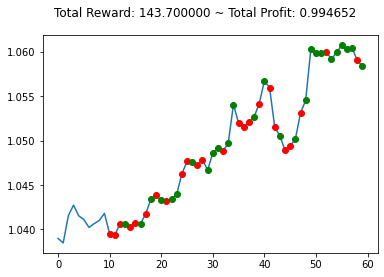

In [ ]:
import gym
import gym_anytrading
import matplotlib.pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.utils import set_random_seed
env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
#env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)
env.seed(0)
set_random_seed(0)
state = env.reset()
while True:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: print(info); break
plt.cla()
env.render_all()
plt.show()
#red dot = predicted to fall = buy stocks
#green dot = predicted to rise = sell stocks
env.close()

In [ ]:
import torch
import torch.nn as nn
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the features extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super().__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf
        self.hidden_size = 256

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):

        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [ ]:
env.close()

In [ ]:
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import os
import numpy as np
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
log_dir = './logs_ch08'
os.makedirs(log_dir, exist_ok=True)

frame=(10, 1000)
window = 10
env = gym.make('stocks-v0', frame_bound=frame, window_size=window)
print("> max_possible_profit:", env.max_possible_profit())
env = Monitor(env, log_dir, allow_early_resets=True)
env.seed(0)
set_random_seed(0)
env = DummyVecEnv([lambda: env])
eval_env = DummyVecEnv([lambda: gym.make('stocks-v0', frame_bound=frame, window_size=window)])
# model = PPO('MlpPolicy', env, verbose=0)
# model = PPO.load('./FXtrade_model_best/best_model.zip', env=env)
# model = PPO(CustomActorCriticPolicy, env, verbose=0, batch_size=4, clip_range=0.2, clip_range_vf=0.2, n_epochs=6, learning_rate=3e-4,
#             policy_kwargs=dict(net_arch=[64, 16]))
# eval_callback = EvalCallback(eval_env, best_model_save_path="./FXtrade_model_best/",
#                              log_path=log_dir, eval_freq=8000, deterministic=True, render=False)
eval_callback = EvalCallback(eval_env, best_model_save_path="./Stocktrade_model_best/",
                             log_path=log_dir, eval_freq=8000, deterministic=True, render=False)
# model.learn(total_timesteps=12800)
model.learn(total_timesteps=128000, callback = eval_callback)
# model = PPO.load('./FXtrade_model_best/best_model.zip')
frame=(1001, 2000)
window = 10
env = gym.make('stocks-v0', frame_bound=frame, window_size=window) #vecenv disables render_all
env.seed(0)
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    if done: print(info); break
plt.cla()
env.render_all()

plt.show()
#red dot = predicted to fall = buy stocks
#green dot = predicted to rise = sell stocks
env.close()

> max_possible_profit: 321.29764818278966


NameError: ignored

# main experiment codes

In [ ]:
import torch
import torch.nn as nn
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.type_aliases import Schedule
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib.common.recurrent.type_aliases import RNNStates
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
)
from typing import Callable, Dict, List, Optional, Tuple, Type, Union, Any
import datetime
import pytz
from stable_baselines3.common.results_plotter import load_results, ts2xy
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the features extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super().__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf
        self.hidden_size = 512 #128 when success #1

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            # nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            # nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            # nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            # nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, last_layer_dim_pi), nn.ReLU()
        )
        def init_weights(m):
          if type(m) == nn.Linear:
              nn.init.xavier_uniform_(m.weight)
              # nn.init.normal_(m.weight, 0.0, 2.0)
              # m.bias.data.fill_(0.01)
        self.policy_net.apply(init_weights)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, last_layer_dim_vf), nn.ReLU()
        )
        self.value_net.apply(init_weights)

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):

        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

class CustomNetworkForRecurrent(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the features extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 32,
        last_layer_dim_vf: int = 32,
    ):
        super().__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf
        self.hidden_size_a = 512
        self.hidden_size_b = 128

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size_a), nn.ReLU(),
            nn.Linear(self.hidden_size_a, self.hidden_size_b), nn.ReLU(),
            nn.Linear(self.hidden_size_b, self.latent_dim_pi), nn.ReLU()
        )
        def init_weights(m):
          if type(m) == nn.Linear:
              nn.init.xavier_uniform_(m.weight) #nn.init.normal(m.weight, 0.0, 1.0)
              # m.bias.data.fill_(0.01)
        self.policy_net.apply(init_weights)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_size_a), nn.ReLU(),
            nn.Linear(self.hidden_size_a, self.hidden_size_b), nn.ReLU(),
            nn.Linear(self.hidden_size_b, self.latent_dim_vf), nn.ReLU()
        )
        self.value_net.apply(init_weights)
          

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        return self.value_net(features)

class CustomRecurrentActorCriticPolicy(RecurrentActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        net_arch: Optional[Union[List[int], Dict[str, List[int]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        ortho_init: bool = False,
        use_sde: bool = False,
        log_std_init: float = 0.0,
        full_std: bool = True,
        use_expln: bool = False,
        squash_output: bool = False,
        features_extractor_class: Type[BaseFeaturesExtractor] = FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        share_features_extractor: bool = True,
        normalize_images: bool = True,
        optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
        lstm_hidden_size: int = 512,
        n_lstm_layers: int = 4,
        shared_lstm: bool = False,
        enable_critic_lstm: bool = True,
        lstm_kwargs: Optional[Dict[str, Any]] = None,
    ):

        super().__init__(
        observation_space, action_space, lr_schedule, net_arch, activation_fn,
        ortho_init, use_sde, log_std_init, full_std, use_expln, squash_output,
        features_extractor_class, features_extractor_kwargs, share_features_extractor,
        normalize_images, optimizer_class, optimizer_kwargs, lstm_hidden_size,
        n_lstm_layers, shared_lstm, enable_critic_lstm, lstm_kwargs,
    )

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetworkForRecurrent(self.lstm_output_dim)

def callback(_locals, _globals):
    global num_update
    global best_mean_reward
    if (num_update+1)%200 == 0:
        _, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(y) > 0:
            mean_reward = np.mean(y[-10:])
            update_model = mean_reward > best_mean_reward
            if update_model:
                best_mean_reward = mean_reward
                _locals['self'].save('./Forex-latestmodel.zip')
            print(f"time: {datetime.datetime.now(pytz.timezone('Asia/Tokyo'))}, num_update: {num_update}, mean: {mean_reward}, best_mean: {best_mean_reward}, updated?: {update_model}")
        num_update+=1
        return True

In [ ]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl import config_tickers
import os
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import (
    INDICATORS,
)
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import numpy as np
import pandas as pd
import itertools

def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    # print(env.df)
    return prices, signal_features

def base_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy() #[start:end]
    prices[env.frame_bound[0] - env.window_size]  # validate index (TODO: Improve validation)
    # prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)
    env.df['diff'] = diff #[start:end]
    # signal_features = np.column_stack((prices, diff))
    # signal_features = env.df.loc[:, ['High', 'Low', 'diff']].to_numpy()
    env.df = env.df.reset_index()
    env.df = env.df.rename(columns={'Date': 'date', 'Open':'open', 'Close': 'close', 'High': 'high', 'Low': 'low'})
    env.df['tic'] = 'GGL'
    env.df['date'] = env.df['date'].astype(str)
    # print(env.df)
    fe = FeatureEngineer(use_technical_indicator=True,
                        tech_indicator_list = INDICATORS,
                        use_vix=True,
                        use_turbulence=True,
                        user_defined_feature = False)
    env.df = fe.preprocess_data(env.df)
    prices = env.df.loc[:, 'close'].to_numpy()
    # signal_features = env.df.loc[:, ['high', 'low', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence']].to_numpy()
    signal_features = env.df.loc[:, ['macd', 'boll_ub', 'boll_lb', 'cci_30', 'vix']].to_numpy()
    return prices[start:end], signal_features[start:end]

class CustomStocksEnv(StocksEnv):
    _process_data = base_process_data #my_process_data

def base_process_data_2(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'close'].to_numpy() #[start:end]
    prices[env.frame_bound[0] - env.window_size]  # validate index (TODO: Improve validation)
    # prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)
    env.df['diff'] = diff #[start:end]
    env.df = env.df.reset_index()
    env.df = env.df.rename(columns={'Date': 'date', 'Open':'open', 'Close': 'close', 'High': 'high', 'Low': 'low'})
    env.df['date'] = env.df['date'].astype(str)
    prices = env.df.loc[:, 'close'].to_numpy() #[start:end]
    # signal_features = env.df.loc[:, ['high', 'low', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence']].to_numpy()
    signal_features = env.df.loc[:, ['macd', 'boll_ub', 'boll_lb', 'cci_30', 'vix']].to_numpy()
    return prices[start:end], signal_features[start:end]

class CustomStocksEnv_2(StocksEnv):
    _process_data = base_process_data_2 #my_process_data

    def _calculate_reward(self, action):
        step_reward = 0
        if action == Actions.Buy.value:
            current_price = self.prices[self._current_tick]
            next_price = self.prices[self._current_tick+1] if self._current_tick+1<len(self.prices) else current_price
            price_diff = next_price-current_price
            # step_reward+=price_diff
            step_reward+=1 if price_diff>=0 else -1
            # step_reward*1 if price_diff>=0 else -1
            # step_reward=0
        else:
            current_price = self.prices[self._current_tick]
            next_price = self.prices[self._current_tick+1] if self._current_tick+1<len(self.prices) else current_price
            price_diff = next_price-current_price
            # step_reward-=price_diff
            step_reward+=1 if price_diff<=0 else -1
            # step_reward*=1 if price_diff<=0 else -1 #price_diff*0.7
            # step_reward*=1.5

        # step_reward = self._total_profit-1.0
        return step_reward


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (94331, 8)


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
Using cpu device
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (94331, 8)


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


ストリーミング出力は最後の 5000 行に切り捨てられました。
|    value_loss           | 0.45        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 699         |
|    ep_rew_mean          | 584         |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 154         |
|    time_elapsed         | 3305        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.074996874 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 0.326       |
|    learning_rate        | 4e-05       |
|    loss                 | 13.9        |
|    n_updates            | 1530        |
|    policy_gradient_loss | -0.0372     |
|    value_loss           | 0.357       |
-----------------------------------------
--

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
{'total_reward': 416.07574999999997, 'total_profit': 0.6534925672632288, 'position': 0}
result


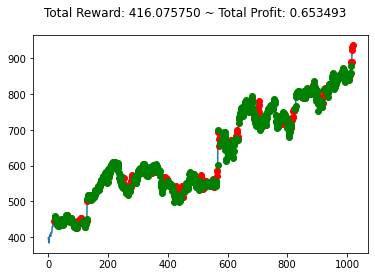

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
{'total_reward': 431.486146, 'total_profit': 0.6514300517088962, 'position': 0}
result


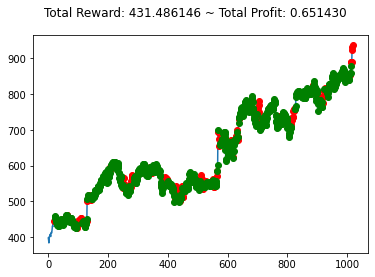

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
{'total_reward': 440.43914700000033, 'total_profit': 0.7812309755331872, 'position': 0}
result


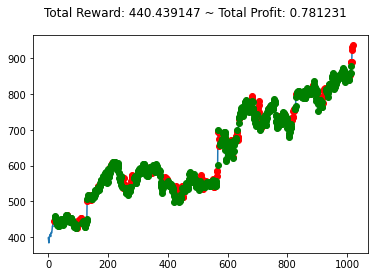

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
{'total_reward': 526.8132060000002, 'total_profit': 0.8216860481093371, 'position': 0}
result


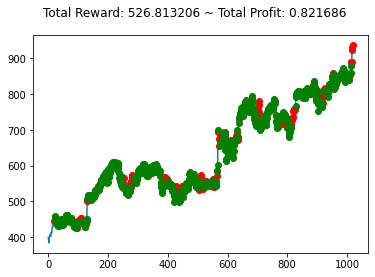

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
{'total_reward': 406.7944969999998, 'total_profit': 0.6546529281059458, 'position': 0}
result


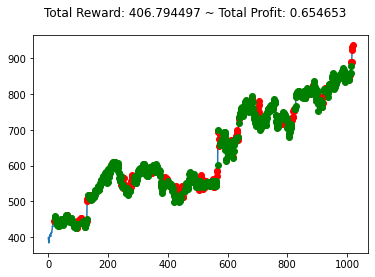

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
{'total_reward': 493.186376, 'total_profit': 0.7304720012355693, 'position': 0}
result


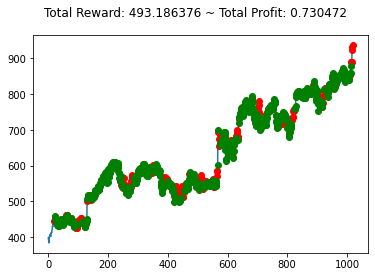

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
{'total_reward': 392.82809600000013, 'total_profit': 0.6570340882781128, 'position': 0}
result


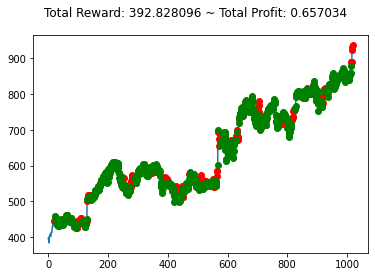

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
{'total_reward': 495.917451, 'total_profit': 0.7615976576485476, 'position': 0}
result


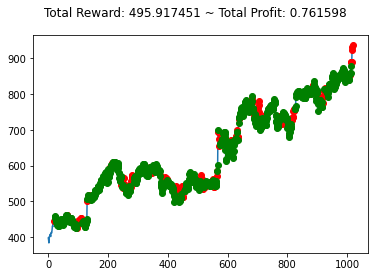

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix


/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index
{'total_reward': 552.9485810000001, 'total_profit': 0.9100794826691221, 'position': 0}
result


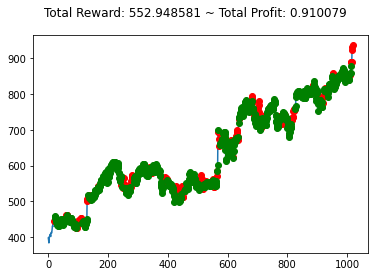

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/usr/local/lib/python3.9/dist-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df


Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
{'total_reward': 509.44888699999984, 'total_profit': 0.6499796687911829, 'position': 0}
result


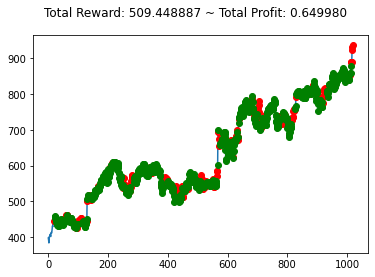

average final profit: 0.727165546934313


In [ ]:
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
import os
import numpy as np
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
# from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO
log_dir = './logs_ch08'
os.makedirs(log_dir, exist_ok=True)
import numpy as np
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def prepare_data_fromfin(tic): #['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
    TRAIN_START_DATE = '2009-01-01'
    TRAIN_END_DATE = '2020-07-01'
    TRADE_START_DATE = '2020-07-01'
    TRADE_END_DATE = '2021-10-31'
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                        end_date = TRADE_END_DATE,
                        ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
    fe = FeatureEngineer(use_technical_indicator=True,
                        tech_indicator_list = INDICATORS,
                        use_vix=True,
                        use_turbulence=True,
                        user_defined_feature = False)
    processed = fe.preprocess_data(df)
    list_ticker = processed["tic"].unique().tolist()
    list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
    combination = list(itertools.product(list_date,list_ticker))

    processed = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
    processed = processed[processed['date'].isin(processed['date'])]
    processed = processed.sort_values(['date','tic'])
    # processed = processed.fillna(0)
    processed = processed.dropna()
    processed = processed[processed['tic']==tic]
    train = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE)
    return train

frame=(33,200)
window = 20
env = CustomStocksEnv_2(df=prepare_data_fromfin('AAPL'), window_size=window, frame_bound=frame)
# print("> max_possible_profit:", env.max_possible_profit())
env = Monitor(env, log_dir, allow_early_resets=True)
env.seed(0)
set_random_seed(0)
env = DummyVecEnv([lambda: env])
# # eval_env = DummyVecEnv([lambda: gym.make(env_id, frame_bound=(201, 300), window_size=50)])
# # model = PPO.load('./FXtrade_model_best/best_model.zip', env=env)

"""
class sb3_contrib.common.recurrent.policies.RecurrentActorCriticPolicy(observation_space, action_space, lr_schedule, net_arch=None,
activation_fn=<class 'torch.nn.modules.activation.Tanh'>, ortho_init=True, use_sde=False, log_std_init=0.0, full_std=True, use_expln=False,
squash_output=False, features_extractor_class=<class 'stable_baselines3.common.torch_layers.FlattenExtractor'>, features_extractor_kwargs=None,
share_features_extractor=True, normalize_images=True, optimizer_class=<class 'torch.optim.adam.Adam'>, optimizer_kwargs=None, lstm_hidden_size=256,
n_lstm_layers=1, shared_lstm=False, enable_critic_lstm=True, lstm_kwargs=None)
"""
# policy_kwargs = dict(activation_fn=nn.modules.activation.ReLU)
with_callback=False
# model = RecurrentPPO('MlpLstmPolicy', env, verbose=1 if not with_callback else 0, batch_size=16, clip_range=0.3, clip_range_vf=0.3, n_epochs=20, learning_rate=4e-4, policy_kwargs=policy_kwargs)
# policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
# model = A2C(CustomActorCriticPolicy, env, verbose=1, learning_rate=0.00002, vf_coef=0.6, ent_coef=0.15)
# model = PPO(CustomActorCriticPolicy, env, verbose=1, learning_rate=0.00005, vf_coef=0.6, ent_coef=0.15, batch_size=256) #window=30, layer=(5, 4) success example #1
model = PPO(CustomActorCriticPolicy, env, verbose=1, learning_rate=0.00004, vf_coef=30.0, ent_coef=0.1, batch_size=128, gamma=0.7)
# model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.00005, vf_coef=1.5, ent_coef=0.01, batch_size=8, gamma=0.99)
# model = RecurrentPPO(CustomRecurrentActorCriticPolicy, env, verbose=1 if not with_callback else 0,
#                      batch_size=32, clip_range=0.2, clip_range_vf=0.15, n_epochs=8, learning_rate=3e-6)
# model.learn(total_timesteps=2000000)
# model.learn(total_timesteps=51200, callback=eval_callback)
model.save('./Stocks-latestmodel.zip')
# model = PPO.load('./Stocks-latestmodel.zip')
# model.save('./Stocks-latestmodel.zip')
# ticlist = ['AAPL', 'CSCO', 'CVX', 'JPM', 'VZ', 'WMT', 'GS', 'HD', 'HON', 'IBM', 'INTC']
#['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
traintic = {'AMGN':(1500,2000), 'CAT':(500,1000), 'CSCO':(100,1000), 'DIS':(1600,2000), 'GS':(500,1200), 'IBM':(1200,2200)}
testtic = {'AXP':(1400,2100)}
# testtic = {'AAPL':(2000,3000), 'WBA':(1000,1700), 'HD':(100,1000), 'AXP':(1400,2100), 'BA':(2300,2700), 'MSFT':(300,800), 'CVX':(1300,1700), 'MMM':(2300,3000), 'KO':(2700,3000)} #first 3 tic is growing, next 3 is so-so, last 3 is decaying
for tic, frame in testtic.items():
  env = CustomStocksEnv_2(df=prepare_data_fromfin(tic), window_size=window, frame_bound=frame)
  print(f">company: {tic}, max_possible_profit: {env.max_possible_profit()}")
  # plt.cla()
  # env.reset()
  # env.render()
  # plt.show()
  env = Monitor(env, log_dir, allow_early_resets=True)
  env.seed(0)
  set_random_seed(0)
  env = DummyVecEnv([lambda: env])
  model = PPO.load('./Stocks-latestmodel.zip', env=env)
  print(f"start training with company {tic}")
  model.learn(total_timesteps=800000)
  model.save('./Stocks-latestmodel.zip')

# frame=(900, 1100)
# window = 10
# env = gym.make(env_id, frame_bound=frame, window_size=window) #vecenv disables render_all
testtic = {'AMGN':(1500,2000)}
# for tic, frame in testtic.items():
rew_sum = 0.0
for i in range(10):
  # env = CustomStocksEnv_2(df=prepare_data_fromfin(tic), window_size=window, frame_bound=frame)
  # env = CustomStocksEnv_2(df=prepare_data_fromfin('AAPL'), window_size=window, frame_bound=frame)
  env = CustomStocksEnv(df=STOCKS_GOOGL, window_size=20, frame_bound=(1000, 2000))
  # print(f">company: {tic}, max_possible_profit: {env.max_possible_profit()}")
  env.seed(0)
  state = env.reset()
  while True:
      action, _ = model.predict(state, deterministic=False)
      state, reward, done, info = env.step(action)
      if done: print(info); rew_sum+=info['total_profit']; break
  plt.cla()
  env.render_all()

  print("result")
  plt.show()
#red dot = predicted to fall = buy stocks
#green dot = predicted to rise = sell stocks
env.close()
print("average final profit:", rew_sum/10)
#{'total_reward': 29.925291000000016, 'total_profit': 0.6017658546345597, 'position': 0}

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
> max_possible_profit: 179.9029967181229
{'total_reward': 346.88189200000005, 'total_profit': 0.5759513546253987, 'position': 1}


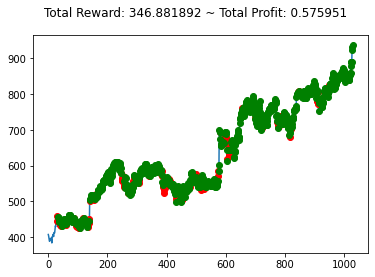

In [ ]:
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
# from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO
log_dir = './logs_ch08'
os.makedirs(log_dir, exist_ok=True)

#test only
frame=(1000, 2000)
# window = 2
# model = A2C.load('./Stocks-latestmodel', device='cpu')
model = PPO.load('./Stocks-latestmodel', device='cpu')
# model = RecurrentPPO.load('./Stocks-latestmodel', device='cpu')
# model = RecurrentPPO.load('./FXtrade_model_best/best_model.zip', device='cpu')
# model = RecurrentPPO.load('./Forex-latestmodel.zip', device='cpu')
env_id = 'stocks-v0'
env = CustomStocksEnv(df=STOCKS_GOOGL, window_size=window, frame_bound=frame)
# env = gym.make(env_id, frame_bound=frame, window_size=window)
env.seed(0)
print("> max_possible_profit:", env.max_possible_profit())
for episode in range(1):
  state = env.reset()
  lstm_states = None
  episode_starts = np.ones((1,), dtype=bool)
  while True:
      # action, lstm_state = model.predict(observation=state, state=lstm_states, episode_start=episode_starts)
      action, _ = model.predict(observation=state, deterministic=True)
      state, reward, done, info = env.step(action)
      episode_starts = done
      if done: print(info); break
  plt.cla()
  env.render_all()
  plt.show()
  #red dot = predicted to fall = sell stocks
  #green dot = predicted to rise = buy stocks
  env.close()
  # {'total_reward': 218.63129000000038, 'total_profit': 0.3283567301765021, 'position': 1}

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2334, 8)
Successfully added vix
Successfully added turbulence index
50


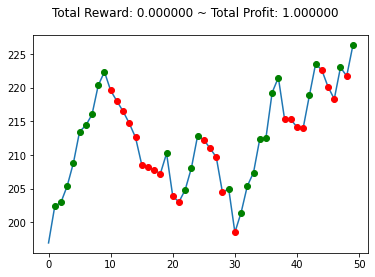

In [ ]:
def base_process_data_3(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'close'].to_numpy() #[start:end]
    prices[env.frame_bound[0] - env.window_size]  # validate index (TODO: Improve validation)
    # prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)
    env.df['diff'] = diff #[start:end]
    # signal_features = np.column_stack((prices, diff))
    # signal_features = env.df.loc[:, ['High', 'Low', 'diff']].to_numpy()
    # print(env.df, signal_features)
    env.df = env.df.reset_index()
    env.df = env.df.rename(columns={'Date': 'date', 'Open':'open', 'Close': 'close', 'High': 'high', 'Low': 'low'})
    env.df['date'] = env.df['date'].astype(str)
    # signal_features = env.df.loc[:, ['high', 'low', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence']].to_numpy()
    signal_features = env.df.loc[:, ['macd', 'boll_ub', 'boll_lb', 'cci_30', 'vix']].to_numpy()
    return prices[start:end], signal_features[start:end]

class CustomStocksEnv_3(StocksEnv):
    _process_data = base_process_data #my_process_data

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.
        self._position_history.pop()

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                    position = Positions.Short
                    self._position_history.append(position)
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                    position = Positions.Long
                    self._position_history.append(position)

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1
        
        print(len(self._position_history))
        return profit

env = CustomStocksEnv_3(df=STOCKS_GOOGL, window_size=1, frame_bound=(1, 50))
env.reset()
env.max_possible_profit()
env.render_all()

# FinRL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint
import sys
sys.path.append("../FinRL")
import itertools
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832626,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.365303,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579327,7117200,CAT,4


In [ ]:
# df.drop(['tic', 'day'], inplace=True)
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)
processed = fe.preprocess_data(df)
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
print(list_ticker)

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index
['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,746015200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,2.758535,2.758535,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832626,6547900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.832626,43.832626,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365303,10955700.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,15.365303,15.365303,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579327,7117200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,31.579327,31.579327,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.948337,40980600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,11.948337,11.948337,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,43.677197,13695900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.677197,43.677197,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597500,9796600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,20.597500,20.597500,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,69.747604,14088500.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,69.747604,69.747604,39.189999,0.0


In [ ]:
# processed_full[processed_full['tic']=='AAPL']

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,7.460152e+08,4.0,0.000000,2.981390,2.652101,100.000000,66.666667,100.000000,2.758535,2.758535,39.189999,0.000000
87,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.874956,1.181608e+09,0.0,0.002612,2.981390,2.652101,100.000000,66.666667,100.000000,2.816745,2.816745,39.080002,0.000000
116,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.827537,1.289310e+09,1.0,0.001858,2.937429,2.703256,70.355488,46.842087,100.000000,2.820342,2.820342,38.560001,0.000000
145,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.766438,7.530488e+08,2.0,-0.000737,2.916617,2.697116,50.429174,-29.702442,43.607834,2.806866,2.806866,43.389999,0.000000
174,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.817809,6.735008e+08,3.0,-0.000087,2.904604,2.713506,60.227017,-9.078813,48.357918,2.809055,2.809055,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135604,2021-10-22,AAPL,149.690002,150.179993,148.639999,147.391525,5.888340e+07,4.0,0.571957,148.810576,136.602037,54.510440,111.309212,9.255682,143.627689,145.828034,15.430000,110.005200
135691,2021-10-25,AAPL,148.679993,149.369995,147.619995,147.341980,5.072060e+07,0.0,0.717888,149.292270,136.444488,54.442578,98.263498,3.092989,143.597621,145.877568,15.240000,22.741448
135720,2021-10-26,AAPL,149.330002,150.839996,149.009995,148.016037,6.089340e+07,1.0,0.877811,149.963221,136.508066,55.227053,126.298902,10.840686,143.637272,145.943945,15.980000,20.607017
135749,2021-10-27,AAPL,149.360001,149.729996,148.490005,147.550156,5.609490e+07,2.0,0.955939,150.478741,136.589292,54.555377,106.614703,7.588151,143.631325,145.972204,16.980000,145.285563


In [ ]:
# mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
processed_full=processed_full[processed_full['tic']=='AAPL']
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2893
336


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [ ]:
buy_cost_list = sell_cost_list = [0.003] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# PPO training

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=64000)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo
------------------------------------
| time/              |             |
|    fps             | 621         |
|    iterations      | 1           |
|    time_elapsed    | 3           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.033973366 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002530364 |
|    clip_fraction        | 0.00405     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.0283     |
|    learning_rate        | 0.00025     |


In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
trained_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df_result_ppo['account_value'])
df_result_ppo
# plt.show()

hit end!


,account_value
date,
2020-07-01,1.000000e+06
2020-07-02,9.999834e+05
2020-07-06,1.000264e+06
2020-07-07,1.000193e+06
2020-07-08,1.000705e+06
...,...
2021-10-22,1.284962e+06
2021-10-25,1.284530e+06
2021-10-26,1.290406e+06


# A2C training

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=64000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
-----------------------------------------
| time/                 |               |
|    fps                | 444           |
|    iterations         | 100           |
|    time_elapsed       | 1             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -1.5          |
|    explained_variance | 0             |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | 4.09e-05      |
|    reward             | 0.00026927463 |
|    std                | 1.09          |
|    value_loss         | 2.05e-07      |
-----------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 440      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df_result_a2c['account_value'])
df_result_a2c
# plt.show()

hit end!


,account_value
date,
2020-07-01,1.000000e+06
2020-07-02,9.999732e+05
2020-07-06,1.000425e+06
2020-07-07,1.000312e+06
2020-07-08,1.001138e+06
...,...
2021-10-22,1.342604e+06
2021-10-25,1.342153e+06
2021-10-26,1.348293e+06


In [ ]:
#merge result
result = pd.merge(df_result_a2c, df_result_ppo, left_index=True, right_index=True)
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
# result
plt.show()

<Figure size 1080x360 with 0 Axes>

# 参考: Optuna

In [ ]:
""" Optuna example that optimizes the hyperparameters of
a reinforcement learning agent using A2C implementation from Stable-Baselines3
on an OpenAI Gym environment CartPole.

This is a simplified version of what can be found in https://github.com/DLR-RM/rl-baselines3-zoo.

You can run this example as follows:
    $ python sb3_simple.py

"""
from typing import Any
from typing import Dict
import gym
import gym_anytrading
import matplotlib.pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch
import torch.nn as nn

N_TRIALS = 100
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = int(2e3)
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CartPole-v1"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}


def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for A2C hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    ortho_init = trial.suggest_categorical("ortho_init", [False, True])
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

    # Display true values.
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("gae_lambda_", gae_lambda)
    trial.set_user_attr("n_steps", n_steps)

    net_arch = [
        {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
    ]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn,
            "ortho_init": ortho_init,
        },
    }

def sample_ppo_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for PPO hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    ortho_init = trial.suggest_categorical("ortho_init", [False, True])
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

    # Display true values.
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("gae_lambda_", gae_lambda)
    trial.set_user_attr("n_steps", n_steps)

    net_arch = [
        {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
    ]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn,
            "ortho_init": ortho_init,
        },
    }

class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


def objective(trial: optuna.Trial) -> float:
    kwargs = DEFAULT_HYPERPARAMS.copy()
    # Sample hyperparameters.
    kwargs.update(sample_a2c_params(trial))
    # Create the RL model.
    model = A2C(**kwargs)
    # Create env used for evaluation.
    eval_env = Monitor(gym.make(ENV_ID))
    # Create the callback that will periodically evaluate and report the performance.
    eval_callback = TrialEvalCallback(
        eval_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward


if __name__ == "__main__":
    # Set pytorch num threads to 1 for faster training.
    torch.set_num_threads(1)

    sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
    # Do not prune before 1/3 of the max budget is used.
    pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

    study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
    try:
        study.optimize(objective, n_trials=N_TRIALS, timeout=600)
    except KeyboardInterrupt:
        pass

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    print("  User attrs:")
    for key, value in trial.user_attrs.items():
        print(f"    {key}: {value}")